<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation/blob/master/src/CVAECifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Variables

In [0]:
IMAGE_COUNT = 50000
TRAINING_IMAGE = 0
TEST_IMAGE = 0
BATCH_SIZE = 1000
VAE_EPOCHS = 50
LATENT_DIM = 50
LOAD_VAE_MODEL = False
INPUT_IMAGE = 10
TRAIN_BUF = 60000
TEST_BUF = 10000

# Import Statements

In [48]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

import tensorflow as tf
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import datasets, layers, models, backend, utils, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive, files

drive.mount("/content/gdrive", force_remount=True)
base_dir = "/content/gdrive/My Drive/DeterministicConvNetCifar10/"

Mounted at /content/gdrive


# Load Dataset

In [0]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert Classification Images to Grayscale

In [0]:
train_gray_images = tf.image.rgb_to_grayscale(train_images[:IMAGE_COUNT])
test_gray_images = tf.image.rgb_to_grayscale(test_images[:IMAGE_COUNT])

# Load the Classification Model

In [51]:
model_dir = os.path.dirname(base_dir + "classification.h5")

json_file = open(base_dir + "classification.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
classification_model = models.model_from_json(loaded_model_json)
classification_model.load_weights(base_dir + "classification.h5", by_name=False)

opt = optimizers.SGD(lr=0.001, momentum=0.9)
classification_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

print("Loaded model from disk")

Loaded model from disk


# Classification Results

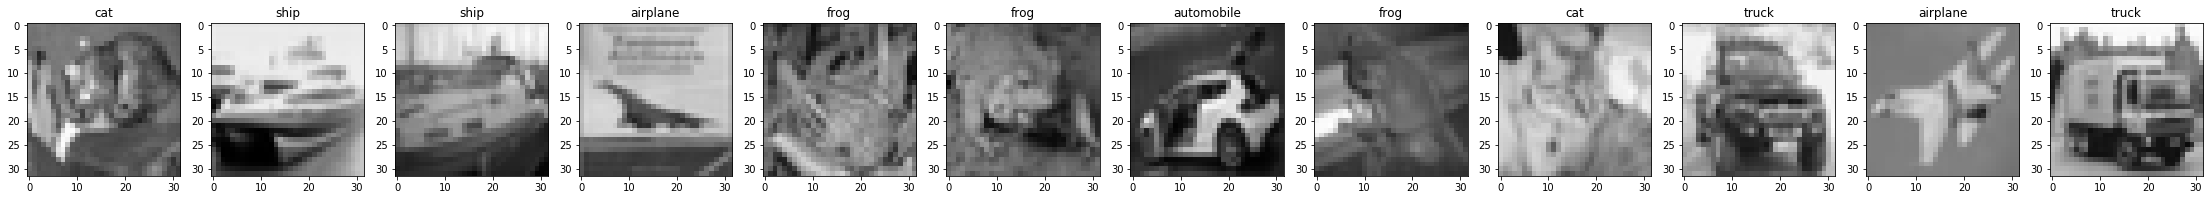

In [52]:
image_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

output_count = 12

fig = plt.figure(figsize=(39,39))
for i in range(output_count):
  result = classification_model.predict_classes(tf.expand_dims(test_gray_images[i], 0))
  fig.add_subplot(1,output_count,i+1)
  plt.title(image_labels[int(result)])
  plt.imshow(tf.image.grayscale_to_rgb(test_gray_images[i]))

# Evaluate Image Class

Predicted image class: [0] - airplane


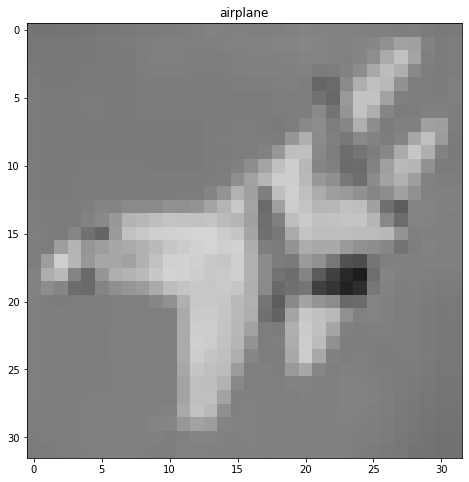

In [53]:
result = classification_model.predict_classes(tf.expand_dims(test_gray_images[INPUT_IMAGE], 0))
print("Predicted image class:", result, "-", image_labels[int(result)])
fig = plt.figure(figsize=(8,8))
plt.title(image_labels[int(result)])
plt.imshow(tf.image.grayscale_to_rgb(test_gray_images[INPUT_IMAGE]))

class_train_indices = np.argwhere(train_labels == result)
class_train_images = train_images[class_train_indices[:,0]]
class_test_indices = np.argwhere(test_labels == result)
class_test_images = test_images[class_test_indices[:,0]]

# Convert Colourisation Images to YUV

In [0]:
# Outputs a tensor of the same shape as the images tensor, containing the YUV 
# value of the pixels. The output is only well defined if the value in images 
# are in [0,1].
#https://zhengtq.github.io/2018/12/27/tensorflow-disturb-yuv/

train_yuvImages = tf.image.rgb_to_yuv(class_train_images[:IMAGE_COUNT])
train_y = tf.expand_dims(train_yuvImages[:,:,:,0], 3)
train_uv = train_yuvImages[:,:,:,1:]

test_yuvImages = tf.image.rgb_to_yuv(class_test_images[:IMAGE_COUNT])
test_y = tf.expand_dims(test_yuvImages[:,:,:,0], 3)
test_uv = test_yuvImages[:,:,:,1:]

# Create the VAE Network

In [60]:
def create_colourisation_encoder():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2, input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Flatten())
  model.add(layers.Dense(LATENT_DIM + LATENT_DIM))
  return model

create_colourisation_encoder().summary()

def create_colourisation_decoder():
  model = models.Sequential()
  model.add(layers.InputLayer(input_shape=(LATENT_DIM,)))
  model.add(layers.Dense(8, activation=tf.nn.relu))
  model.add(layers.Reshape((2, 2, 2)))
  model.add(layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2DTranspose(2, (3, 3), padding='same', strides=2))
  # opt = optimizers.RMSprop(lr=0.0001, momentum=0.0)
  # model.compile(optimizer=opt, loss='mse')
  return model

create_colourisation_decoder().summary()

def create_colourisation_generator():
    model = models.Sequential()
    model.add(layers.Conv2D(8, (3, 3), input_shape=(32, 32, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(16, (3, 3), padding='same', strides=2))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(32, (3, 3), padding='same', strides=2))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), padding='same', strides=2))
    model.add(layers.LeakyReLU())
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(16, (3, 3), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
    return model

create_colourisation_generator().summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 16, 16, 32)        320       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
flatten_10 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               409700    
Total params: 428,516
Trainable params: 428,516
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 8)                 408       
________________________

In [0]:


class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(32, 32, 2)),
          tf.keras.layers.Conv2D(
              filters=16, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=8, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(2, 2, 2)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
         tf.keras.layers.Conv2DTranspose(
              filters=16,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
         tf.keras.layers.Conv2DTranspose(
              filters=8,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=2, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  # Sample from the latent space by first sampling from from a unit Gaussian, 
  # and then multiplying by the standard deviation and adding the mean.
  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

# Define Loss Function and Optimiser

In [0]:
# VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood
# In statistics, the evidence lower bound (ELBO, also variational lower bound or negative variational free energy) is the quantity optimized in Variational Bayesian methods.
# In practice, we optimize the single sample Monte Carlo estimate of this expectation

optimizer = optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))



# Train the Colourisation Model

In [58]:
# Does this need to be shuffled?
batched_train_y = np.array(np.split(train_y, (train_y.shape[0]/BATCH_SIZE))).astype('float32')
batched_train_uv = np.array(np.split(train_uv, (train_uv.shape[0]/BATCH_SIZE))).astype('float32')
batched_test_y = np.array(np.split(train_y, (test_y.shape[0]/BATCH_SIZE))).astype('float32')
batched_test_uv = np.array(np.split(train_uv, (test_uv.shape[0]/BATCH_SIZE))).astype('float32')

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
model = CVAE(LATENT_DIM)

# def generate_and_save_images(model, epoch, test_input):
#   predictions = model.sample(test_input)
#   fig = plt.figure(figsize=(4,4))

#   for i in range(predictions.shape[0]):
#       plt.subplot(4, 4, i+1)
#       plt.imshow(predictions[i, :, :, 0], cmap='gray')
#       plt.axis('off')

#   # tight_layout minimizes the overlap between 2 sub-plots
#   plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
#   plt.show()

# generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, VAE_EPOCHS + 1):
  start = time.time()
  for i in range(batched_train_uv.shape[0]):
    compute_apply_gradients(model, batched_train_uv[i], optimizer)
  # for train_x in train_dataset:
  #   compute_apply_gradients(model, train_x, optimizer)

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for i in range(batched_train_uv.shape[0]):
      loss(compute_loss(model, batched_train_uv[i]))
    # for test_x in test_dataset:
    #   loss(compute_loss(model, test_x))
    elbo = -loss.result()
    # display.clear_output(wait=False)
    print("Epoch %d/%d - %fs - evidence lower bound: %f" % (epoch, VAE_EPOCHS, time.time()-start, elbo))
    # print('Epoch: {}, Test set ELBO: {}, '
    #       'time elapse for current epoch {}'.format(epoch,
    #                                                 elbo,
    #                                                 end_time - start_time))
    # generate_and_save_images(
    #     model, epoch, batched_train_uv[0])

Epoch 1/50 - 1.672163s - evidence lower bound: -1417.244385
Epoch 2/50 - 0.127931s - evidence lower bound: -1415.423218
Epoch 3/50 - 0.126472s - evidence lower bound: -1413.437622
Epoch 4/50 - 0.120827s - evidence lower bound: -1411.301880
Epoch 5/50 - 0.120893s - evidence lower bound: -1408.804199
Epoch 6/50 - 0.120370s - evidence lower bound: -1405.939453
Epoch 7/50 - 0.122791s - evidence lower bound: -1402.880249
Epoch 8/50 - 0.120925s - evidence lower bound: -1398.707153
Epoch 9/50 - 0.120551s - evidence lower bound: -1394.122925
Epoch 10/50 - 0.121129s - evidence lower bound: -1388.155884
Epoch 11/50 - 0.120439s - evidence lower bound: -1380.640991
Epoch 12/50 - 0.120736s - evidence lower bound: -1370.614746
Epoch 13/50 - 0.122655s - evidence lower bound: -1356.240723
Epoch 14/50 - 0.120886s - evidence lower bound: -1336.321167
Epoch 15/50 - 0.120768s - evidence lower bound: -1307.952881
Epoch 16/50 - 0.121713s - evidence lower bound: -1265.952515
Epoch 17/50 - 0.121513s - evidenc

# Training Results

(12, 50)
(12, 32, 32, 2)


TypeError: ignored

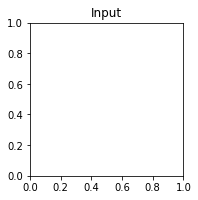

In [59]:
output_count = 12
random_vector_for_generation = tf.random.normal(shape=[output_count, LATENT_DIM])
print(random_vector_for_generation.shape)
predictions = model.sample(random_vector_for_generation)
print(predictions.shape)
# fig = plt.figure(figsize=(4,4))

# for i in range(predictions.shape[0]):
#     plt.subplot(4, 4, i+1)
#     plt.imshow(predictions[i, :, :, 0], cmap='gray')
#     plt.axis('off')

# # print(generator.evaluate(train_y, train_uv))
# output = generator(train_y, training=False)

# result = np.zeros((train_y.shape[0], 32, 32, 3))
# result[:,:,:,0] = train_y[:,:,:,0]
# result[:,:,:,1:] = output

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(predictions[i])

# fig = plt.figure(figsize=(39, 39))
# for i in range(output_count):
#   fig.add_subplot(1,output_count,i+1)
#   plt.title("Original")
#   plt.imshow(class_train_images[TRAINING_IMAGE+i])

# fig = plt.figure(figsize=(39, 39))
# for i in range(output_count):
#   fig.add_subplot(1,output_count,i+1)
#   plt.title("Output")
#   plt.imshow(tf.image.yuv_to_rgb(result[TRAINING_IMAGE+i]))
  
# fig = plt.figure(figsize=(39, 39))
# for i in range(output_count):
#   fig.add_subplot(1,output_count,i+1)
#   plt.title("U original")
#   plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,1])
  
# fig = plt.figure(figsize=(39, 39))
# for i in range(output_count):
#   fig.add_subplot(1,output_count,i+1)
#   plt.title("U output")
#   plt.imshow(result[TRAINING_IMAGE+i,:,:,1])
  
# fig = plt.figure(figsize=(39, 39))
# for i in range(output_count):
#   fig.add_subplot(1,output_count,i+1)
#   plt.title("V original")
#   plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,2])
  
# fig = plt.figure(figsize=(39, 39))
# for i in range(output_count):
#   fig.add_subplot(1,output_count,i+1)
#   plt.title("V output")
#   plt.imshow(result[TRAINING_IMAGE+i,:,:,2])